# Check robustness for p/ks = 1

### Import packages 

In [1]:
import matplotlib.pyplot as plt;
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go
import fiona
from shapely import geometry
from shapely.geometry import MultiLineString, MultiPolygon, Polygon,Point, polygon
from shapely.ops import polygonize
from descartes.patch import PolygonPatch

import pickle
import glob
import itertools as it
import numpy as np;
import pandas as pd;
import os, sys,json
import string
from pandas import *
from textwrap import wrap
from os.path import dirname

from scipy.stats import norm
from scipy import stats

parent_dir = (dirname(os.getcwd()))

current_dir = os.getcwd()

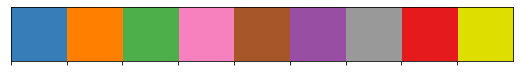

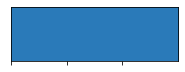

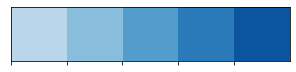

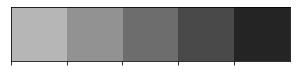

In [2]:
title_font = { 'size':'16', 'color':'black', 'weight':'normal','fontname':'Myriad Pro',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = { 'size':'14','fontname':'Myriad Pro',}
sub_plot = {'size':'18','color':'black', 'fontname':'Myriad Pro',
            'horizontalalignment':'left', 'verticalalignment':'center'}

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
cb=sns.color_palette(CB_color_cycle)

sns.palplot(sns.color_palette(cb))

cmap1 = sns.cubehelix_palette(rot=-.4,as_cmap=True)
cmap2 = sns.cubehelix_palette(rot=0,as_cmap=True)
cmap3 = sns.cubehelix_palette(rot=.4,as_cmap=True)
cmap4 = sns.cubehelix_palette(start=.1,rot=.6,as_cmap=True)
blue=sns.color_palette("Blues")[4]
sns.palplot(blue)
blues=sns.color_palette("Blues")[1:10]
sns.palplot(blues)
blacks=sns.color_palette("binary")[1:10]
newcmp = ListedColormap(blacks)
sns.palplot(blacks)

### Import sve runs

In [3]:
sve_core = pd.read_pickle("./inp_files/SVE_FILES/image_sims_July18.pkl")

for key in sve_core.index:
    sim = sve_core.loc[key]
    scenario = "p-{0},Ks-{1}".format(sim.p,sim.Ks)
    sve_core.loc[key,"scenario"] = scenario
    
scenarios = np.unique(sve_core.scenario)
sims = dict(sve_core.T)
for i, key in enumerate(sims.keys()):
    sim = sims[key]               
    sims[key]['infl_frac'] = np.mean(sim.zinflc)/sim.p/sim.tr*60.

    
sve_core = pd.DataFrame(sims).T  
sve_core=sve_core.reset_index()
new = sve_core["index"].str.split("/", n = 1, expand = True) 

new2 = new[1].str.split("-", n = 1, expand = True) 
new3 = new2[1].str.split("_", n = 1, expand = True) 
new4 = new3[1].str.split(",", n = 1, expand = True) 
sve_core["image"]= new4[0]
sve_core['A_dc']=sve_core['A_CI']*50
sve_core['model']='sve'
sve_core['fI']=1-sve_core['fV']
sve_core['fI']=sve_core['fI'].astype(float).round(1)
sve_core['IF']=sve_core['infl_frac'].astype(float).round(3)
sve_core['p_Ks']=(sve_core['p']/sve_core['Ks']).astype(float).round(2)
sve_core['f_dc']=((sve_core['A_dc'])/(50.*100.*sve_core['fI'])).astype(float).round(3)

sve_core=sve_core[sve_core['image']!='n5511.tif'].copy() #delete repeated image!
sve_core=sve_core[sve_core['image']!='n559.tif'].copy() #delete image 

### Import SWMM runs    

In [4]:
#2 params
with open('out/cal/P-2,dur-30min.pickle', 'rb') as handle:
    P_2 = pickle.load(handle)
#open params and soil pickles
with open('out/cal/P-5,dur-30min.pickle', 'rb') as handle:
    P_5 = pickle.load(handle)
with open('out/cal/P-8,dur-30min.pickle', 'rb') as handle:
    P_8 = pickle.load(handle)
frames=[P_2,P_5,P_8]    


### Combine SVE and SWMM runs

In [5]:
def concat(core,frames,sve_core):
    swmm=pd.concat(frames)
    swmm['total']=swmm['infiltration']+swmm['runoff']
    swmm['IF']=swmm['infiltration']/(swmm['total'])
    swmm['R']=swmm['runoff']/(swmm['total'])
    swmm['p_Ks']=(swmm['P']/swmm['Ks']).astype(float).round(2)
    swmm['fI']=1-swmm['fV']
    swmm['fI']=swmm['fI'].astype(float).round(1)
    swmm['model']='swmm'
    swmm['f_dc']=swmm['A3']/(swmm['A3']+swmm['A1'])
    sve_core2=sve_core[['scenario', 'fI','infl_frac','image']].drop_duplicates()
    core = pd.merge(swmm, sve_core2,  how='inner',on=['scenario', 'fI','image'])
    core['error']=((core['infl_frac']-core['IF'])/core['infl_frac']*100.0).astype(float)
    return core

core_wadc=pd.DataFrame()
core_wadc=concat(core_wadc,frames,sve_core)
core_wadc['K_width']=core_wadc['W']/(50*100)

### Get unique scenario values

In [6]:
scenarios = np.unique(core_wadc.scenario)
images = np.unique(core_wadc.image)
ratios=np.unique(core_wadc.p_Ks)
fIs=np.unique(core_wadc.fI)
Kss=np.unique(core_wadc.Ks)
Ps=np.unique(core_wadc.P)

### Select only the scenarios where p/k = 1

In [7]:
core_wadc=core_wadc[core_wadc['p_Ks']==1].copy()

# Plot calibration parameter error

In [8]:
cmap = sns.diverging_palette(220, 40,s=100, as_cmap=True)
# get absolute errors
core_wadc['error_abs']=abs(core_wadc['error']).copy()

### Calculate 2d histogram


In [9]:

# set x and y bins
binx = np.linspace(0.01-0.005, 0.1+0.005, 11) 
biny = np.linspace(0.0-0.05, 1.0+0.05, 11)

#loop through P scenarios and calculate binned statistics
r=0
hist2d=dict()
for i,scenario in enumerate(Ps):
    dum = core_wadc[core_wadc.P ==scenario]
    dum2=dum.sort_values('fI')
    for j,s in enumerate(fIs):
        dum3 = dum2[dum2.fI ==s]             
        x=dum3['K_width'].values.flatten()
        y=dum3['f_dc'].values.flatten()
        z=abs(dum3['error']).values.flatten()
        H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='mean', bins=[binx, biny])
       
        # get data from 2d histogram
        H = H.T # H is the mean of values within each bin
    
        #5th, 15t, and 25th percentile
        thresh1=np.nanquantile(H,0.05)
        thresh2=np.nanquantile(H,0.15)
        thresh3=np.nanquantile(H,0.25)

        #mask where there is no data
        H = np.ma.masked_where(H==0, H) 
        
        #return hist2d
        hist2d[r]={'p':scenario,'fI':s,'H':H,'H_min':np.nanmin(H),'H_mean':np.round(np.nanmean(H),2),
                   'H_max':np.nanmax(H),'thresh1':thresh1,'thresh2':thresh2,'thresh3':thresh3,'xedges':xedges,'yedges':yedges}
        r=r+1

hist2d=DataFrame(hist2d).T

In [10]:
#define low, medium, and high contour levels
low=np.mean(hist2d['thresh1'])
med=np.mean(hist2d['thresh2'])
high=np.mean(hist2d['thresh3'])
level_max=hist2d['H_max'].max()
levels=[0,low,med,high,level_max+1]
levels

[0,
 3.3660402145271124,
 7.078096109928738,
 9.258708963373515,
 46.29972131753049]

### Plot contours associated with high, medium, and low density levels

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


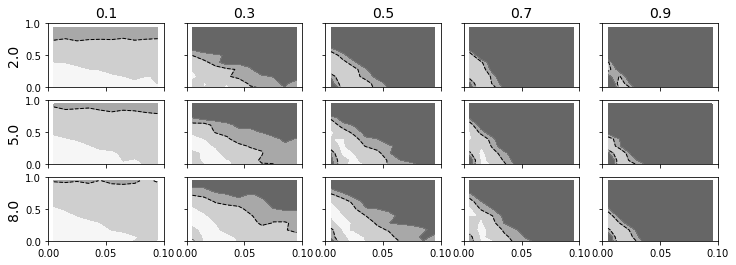

In [11]:
## plot contours

poly_dict=dict()

fig, axes = plt.subplots(3,5,figsize = (12,4), sharex = True,  sharey = True)


for i,scenario in enumerate(Ps):
    dum = hist2d[hist2d.p ==scenario]
    dum2=dum.sort_values('fI')
    for j,s in enumerate(fIs):
        dum3 = dum2[dum2.fI ==s]
        
        levels=[0,low,med,high,level_max+1]
        


        cs = axes[i][j].contourf(np.unique(dum3.xedges)[0][:-1],
                                 np.unique(dum3.yedges)[0][:-1],
                                 np.unique(dum3.H)[0], 
                                 levels=levels,
                                 vmin=0, vmax=level_max+1,
#                                  norm=colors.LogNorm(vmin=.5, vmax=level_max+1),
                                 cmap='binary')
        
            
        cs = axes[i][j].contourf(np.unique(dum3.xedges)[0][:-1],
                                 np.unique(dum3.yedges)[0][:-1],
                                 np.unique(dum3.H)[0], 
                                 levels=[med,high],
                                 colors='grey',zorder=2,alpha=0.5)


        cs = axes[i][j].contourf(np.unique(dum3.xedges)[0][:-1],
                         np.unique(dum3.yedges)[0][:-1],
                         np.unique(dum3.H)[0], 
                         levels=[low,med],
                         colors='grey',zorder=3,alpha=0.2)

            
        cs = axes[i][j].contour(np.unique(dum3.xedges)[0][:-1],
                                 np.unique(dum3.yedges)[0][:-1],
                                 np.unique(dum3.H)[0], 
                                 levels=[0,med],
                                 linewidths=1,
                                linestyles='dashed',
                                    colors='black',zorder=4)


            
        axes[0][j].set_title(s, **axis_font)
        axes[i][0].set_ylabel(scenario,**axis_font)
        axes[i][j].set_xlim(0,0.1)
        axes[i][j].set_ylim(0,1.)

###  Extract behavioral parameter space

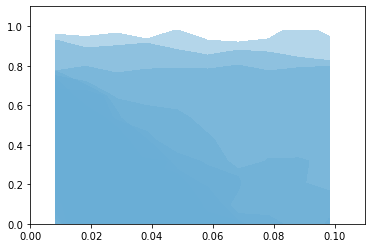

In [12]:
#calculate parameter space, save polygons in a dataframe

poly_all=dict()
r=0

for i,scenario in enumerate(Ps):
    dum = hist2d[hist2d.p ==scenario]
    dum2=dum.sort_values('fI')
    for j,s in enumerate(fIs):
        dum3 = dum2[dum2.fI ==s]
        levels=[0,med]
        xwidth=np.unique(dum3.xedges)[0][2:3]-np.unique(dum3.xedges)[0][1:2]
        ywidth=np.unique(dum3.yedges)[0][2:3]-np.unique(dum3.yedges)[0][1:2]
        
        cs = plt.contourf(np.unique(dum3.xedges)[0][1:]-2*xwidth/3.,
                                 np.unique(dum3.yedges)[0][1:]-2*ywidth/3.,
                                 np.unique(dum3.H)[0], 
                                 levels=levels,
                                 cmap='Blues',alpha=0.5)
        plt.xlim(0.0,0.11)
        plt.ylim(0.0,1.1)

        # loop over collections (and polygons in each collection), store in list for fiona
        area=0
        geometries_list=[]
        
        for k in range(len(cs.collections)):
            area=area
            for j in range(len(cs.collections[k].get_paths())):
                p = cs.collections[k].get_paths()[j]
                v = p.vertices
                x = v[:,0]
                y = v[:,1]
                poly = polygon.Polygon([(k[0], k[1]) for k in zip(x,y)])
                geometries_list+=[poly]
            polygons = MultiPolygon(geometries_list).buffer(0)

        
        poly_all[r]={'p':scenario,'fI':s,'poly':polygons,'area':polygons.area}
        r=r+1

poly_df=DataFrame(poly_all).T

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


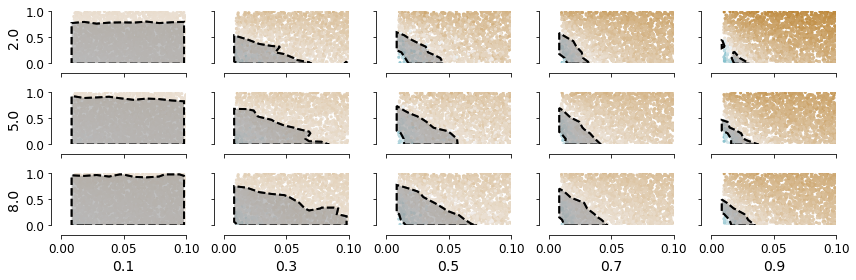

In [13]:
# plot parameter spaces for p/ks = 1 scenarios
# plot errors

fig, axes = plt.subplots(3,5,figsize = (12,4), sharex = True,  sharey = True)

for i,scenario in enumerate(Ps):
    dum = core_wadc[core_wadc.P ==scenario]
    dum_poly = poly_df[poly_df.p ==scenario]
    dum2=dum.sort_values('fI')
    for j,s in enumerate(fIs):
        dum3 = dum2[dum2.fI ==s].reset_index()
        dum2_poly = dum_poly[dum_poly.fI ==s]
        poly= np.unique(dum2_poly['poly'])[0]
      
        pcm=axes[i][j].scatter(dum3['K_width'], dum3['f_dc'],c=dum3['error'],cmap=cmap,lw=0,vmin=-60, vmax=60,s=10)

        patch = PolygonPatch(poly, edgecolor='black',facecolor='grey',zorder=1,lw=2,ls='--',label=s,alpha=0.5)
        patch2 = PolygonPatch(poly, edgecolor='black',facecolor=None,Fill=False,zorder=1,lw=2,ls='--',label=s)
        axes[i][j].add_patch(patch)
        axes[i][j].add_patch(patch2)
        axes[i][j].xaxis.set_major_locator(ticker.MultipleLocator(.05))


#         for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
#             label.set_fontsize(1)  

#         axes[2][j].set_xlabel('$\hat{K}_{width}$',**axis_font)
        axes[i][0].set_ylabel(str(scenario),**axis_font)
        axes[2][j].set_xlabel(s,**axis_font)
        axes[i][j].set_xlim(0,0.1)
        axes[i][j].set_ylim(0,1.)


        
sns.despine(offset=10, trim=False);
axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontname('Myriad Pro')
        label.set_fontsize(12)  
plt.tight_layout()
plt.savefig('P_Ks1_behavA.pdf')

# fig, axes = plt.subplots(1,figsize = (1,4))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-60, vmax=60))
# cbar = fig.colorbar(sm,cax=axes, orientation='vertical',)
# for label in (axes.get_xticklabels() + axes.get_yticklabels()):
#     label.set_fontname('Myriad Pro')
#     label.set_fontsize(14)
# plt.tight_layout()
# plt.savefig('2param_color_small.pdf')
